In [2]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
import pybert as pb

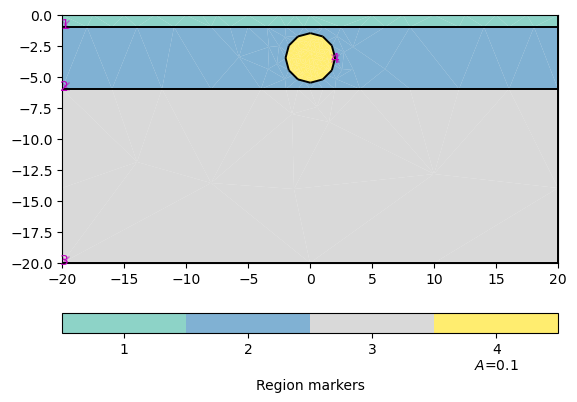

In [3]:
world = mt.createWorld(start=[-20, 0], end=[20, -20], layers=[-1, -6], worldMarker=1)
# Create some heterogeneous circle and merge with world
block = mt.createCircle(pos=[0, -3.5], radius=2, marker=4, boundaryMarker=10, area=0.1)
geom = mt.mergePLC([world, block])
pg.show(geom);

In [4]:
# place electrodes in the mesh and refine them
xEl = np.linspace(-10, 10, 21)
[geom.createNode((x, 0, 0), -99) for x in xEl]
[geom.createNode((x, -0.1, 0)) for x in xEl]
mesh = mt.createMesh(geom)
print(mesh)

Mesh: Nodes: 672 Cells: 1179 Boundaries: 1850


In [5]:
data = ert.createData(elecs=xEl, schemeName='dd')
data["k"] = ert.geometricFactors(data)
print(data)

Data: Electrodes: 21 data: 171


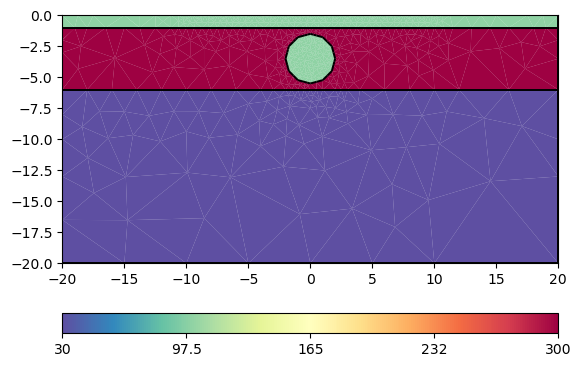

In [6]:
rhoMap = np.array([0, 100, 300, 30, 100], dtype=float)
rhoVec = rhoMap[mesh.cellMarkers()]
pg.show(mesh, rhoVec, cMap="Spectral_r");

19/06/23 - 14:43:42 - pyGIMLi - INFO - Found 1 regions.
19/06/23 - 14:43:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/06/23 - 14:43:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
19/06/23 - 14:43:42 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2522 Cells: 4716 Boundaries: 3700


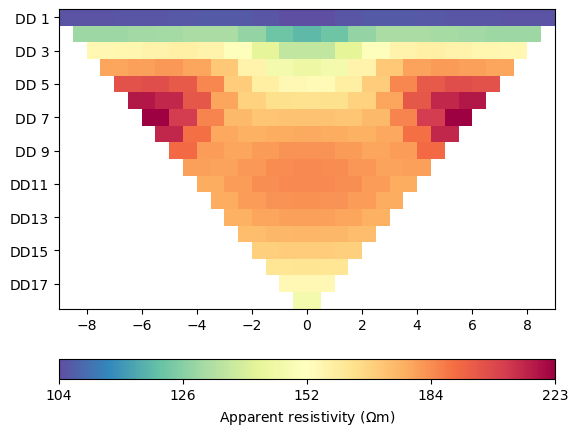

In [7]:
mesh0 = pg.Mesh(mesh)
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopDC = ert.ERTModelling()
fopDC.setMesh(mesh0)
fopDC.setData(data)
data["rhoa"] = fopDC.response(rhoVec)
pg.show(data, "rhoa");

In [8]:
fopDC.createJacobian(rhoVec)

In [9]:
fopIP = pb.tdip.DCIPMModelling(fopDC, mesh, rhoVec)

19/06/23 - 14:43:42 - pyGIMLi - INFO - Found 4 regions.
19/06/23 - 14:43:42 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x194ae3dd2e0>)

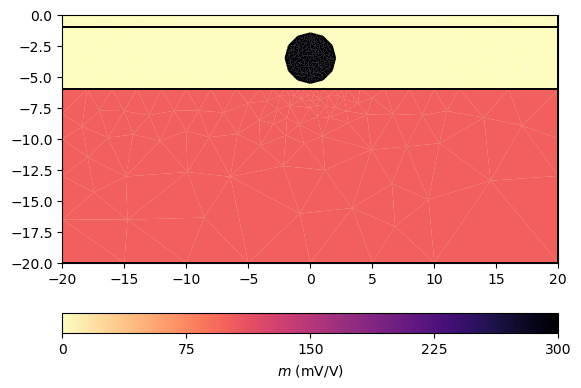

In [10]:
mMap = np.array([0, 0, 0, 0.1, 0.3])  # intrinsic chargeability
mVec = mMap[mesh.cellMarkers()]
pg.show(mesh, mVec*1000, logScale=False, label=r"$m$ (mV/V)", cMap="magma_r", cMin=0, cMax=300)

1

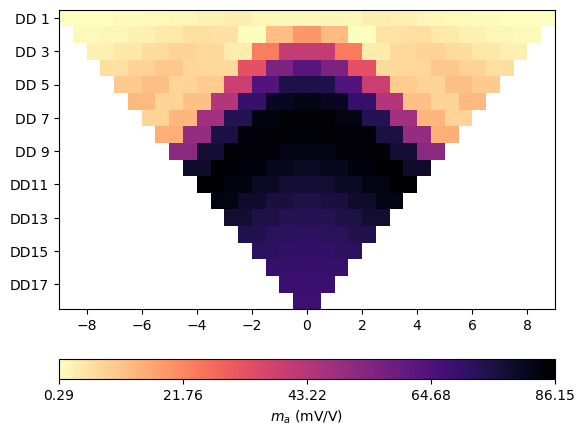

In [11]:
data["ma"] = fopIP.response(mVec)
pg.show(data, data["ma"]*1000, logScale=False, label=r"$m_a$ (mV/V)", cMap="magma_r");
data.save("simpleTDIP.dat", "a b m n rhoa k ma")

19/06/23 - 14:43:43 - pyGIMLi - INFO - Found 2 regions.
19/06/23 - 14:43:43 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
19/06/23 - 14:43:43 - pyGIMLi - INFO - Found 2 regions.
19/06/23 - 14:43:43 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
19/06/23 - 14:43:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/06/23 - 14:43:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
19/06/23 - 14:43:43 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2859 Cells: 5480 Boundaries: 4228
19/06/23 - 14:43:43 - pyGIMLi - INFO - Use median(data values)=174.37618966372395
19/06/23 - 14:43:43 - pyGIMLi - INFO - Created startmodel from forward operator: 793 [174.37618966372395,...,174.37618966372395]
19/06/23 - 14:43:43 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000194B860DCC0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000194B860DE00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000194B860DD60>
min/max (data): 104/223
min/max (error): 3.01%/3.03%
min/max (start model): 174/174
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 4.15 (dPhi = 89.73%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.52 (dPhi = 62.44%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.52)                   #
################################################################################


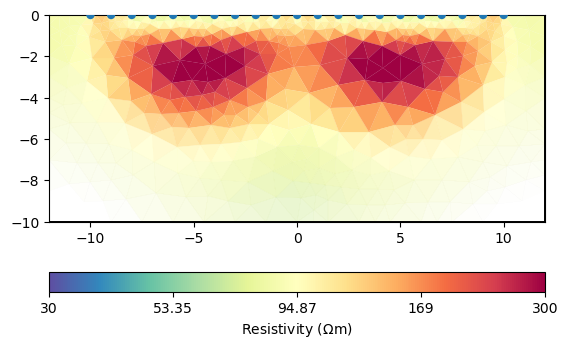

In [12]:
data["err"] = ert.estimateError(data, 0.03)
mgr = ert.Manager(data)
mgr.invert(paraDX=0.25, paraDepth=10, quality=34.4, paraMaxCellSize=1, verbose=1)
mgr.showResult(cMin=30, cMax=300);

19/06/23 - 14:43:45 - pyGIMLi - INFO - Found 793 regions.
19/06/23 - 14:43:45 - pyGIMLi - INFO - Region with smallest marker set to background (marker=0)
19/06/23 - 14:43:45 - pyGIMLi - INFO - Starting inversion.


fop: <pybert.tdip.modelling.DCIPMModelling object at 0x00000194B862D900>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000194B8612880>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612700>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612880>
	 2 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612700>
	 3 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612880>
	 4 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612700>
	 5 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612880>
	 6 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612700>
	 7 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612880>
	 8 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612700>
	 9 <pgcore._pygimli_.RTransLogLU object at 0x00000194B8612880>
................................................................................................................................................................................

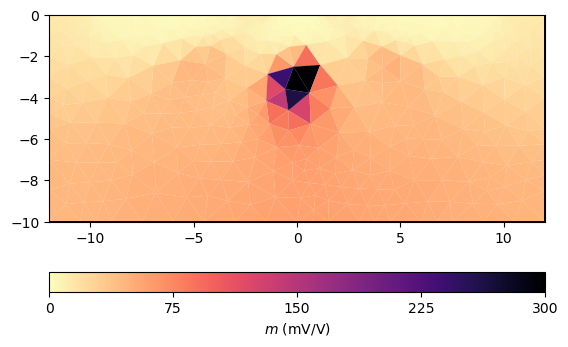

In [13]:
fopIP = pb.tdip.DCIPMModelling(mgr.fop, mgr.paraDomain, mgr.model, response=mgr.inv.response)
fopIP.createRefinedForwardMesh(True)
invIP = pg.Inversion(fop=fopIP, verbose=True)
errorIP = pg.Vector(data.size(), 0.03) + 0.001 / data["ma"]  # absolute ma 1mV/V plus 3%
modelIP = invIP.run(data["ma"], errorIP, startModel=0.1, lam=10, verbose=True)
pg.show(mgr.paraDomain, modelIP*1000, logScale=False, label=r"$m$ (mV/V)", cMap="magma_r", cMin=0, cMax=300);

In [14]:
# alternative
fopIP = pb.tdip.DCIPMModelling(mgr.fop, mgr.mesh, mgr.model, response=mgr.inv.response)
fopIP.createRefinedForwardMesh(True)
fopIP.setRegionProperties(1, background=True)
invIP = pg.Inversion(fop=fopIP, verbose=True)
errorIP = pg.Vector(data.size(), 0.03) + 0.001 / data["ma"]  # absolute ma error important
modelIP = invIP.run(data["ma"], errorIP, startModel=0.1, lam=10, verbose=True)


19/06/23 - 14:43:48 - pyGIMLi - INFO - Found 2 regions.
19/06/23 - 14:43:48 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
19/06/23 - 14:43:48 - pyGIMLi - INFO - Starting inversion.


fop: <pybert.tdip.modelling.DCIPMModelling object at 0x00000194C16A53B0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000194B064C4C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000194C16FAD10>
min/max (data): 2.9e-04/0.09
min/max (error): 4.16%/342%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 855.99 (dPhi = 72.31%) lam: 10
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 51.13 (dPhi = 93.86%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 15.85 (dPhi = 64.95%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 3.03 (dPhi = 66.6%) lam: 10.0
-----------------------------------------------------------------

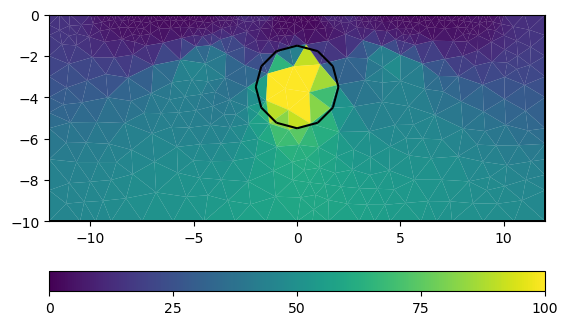

In [15]:
ax, _ = pg.show(mgr.paraDomain, modelIP*1000, logScale=False, cMin=0, cMax=100)
pg.viewer.mpl.drawPLC(ax, block, fillRegion=False)